In [25]:
import numpy as np
from PIL import Image
import cv2
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
import random
from tabulate import tabulate
from tqdm import tqdm
import pandas as pd
from scipy.stats import kurtosis, skew, iqr, norm, t, laplace, beta, multivariate_normal
from collections import Counter
np.set_printoptions(suppress=True)
from mpl_toolkits.mplot3d import Axes3D 

In [26]:
n_images = 250
images = []

while len(images) != n_images:
    idx = random.randint(14, 25000)
    image_name = f'im{idx}.jpg'
    image = cv2.imread(glob.glob(f'./images/mirflickr/{image_name}')[0])[:, :, 1]
    #images.append((image_name, image))
    images.append(image)
    
images = np.asarray(images)
assert len(images) == n_images

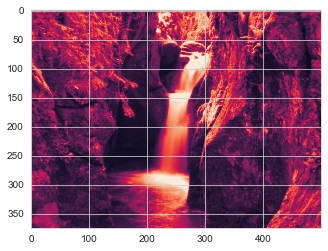

In [27]:
plt.imshow(images[0]);

# Для зеленого каналу кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:
 - Математичне очікування та дисперсію
 - Медіану та інтерквартильний розмах
 - Коефіцієнти асиметрії та ексцесу (нормалізований)
 - Гістограму значень яскравості пікселів (нормалізовану)

In [28]:
def count_statistics(img):
    math_exp_ = np.mean(img)
    variance_ = np.var(img)
    median_ = np.median(img)
    IQR_ = iqr(img.reshape(-1))
    kurtosis_ = kurtosis(img.reshape(-1))
    skew_ = skew(img.reshape(-1))
    return math_exp_, variance_, median_, IQR_, kurtosis_, skew_

In [29]:
def plot_hist(image, distribution_label = None):
    f, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True);
    plt.figure(figsize=(10, 6));
    sns.distplot(image.reshape(-1), kde=False, ax=axes[0]);
    if distribution_label == 't':
        sns.distplot(image.reshape(-1), fit=t, kde=False, ax=axes[1]);
    elif distribution_label == 'beta':
        sns.distplot(image.reshape(-1), fit=beta, kde=False, ax=axes[1]);
    elif distribution_label == 'laplace':
        sns.distplot(image.reshape(-1), fit=laplace, kde=False, ax=axes[1]);
    elif distribution_label == 'norm':
        sns.distplot(image.reshape(-1), fit=norm, kde=False, ax=axes[1]);
    plt.show();

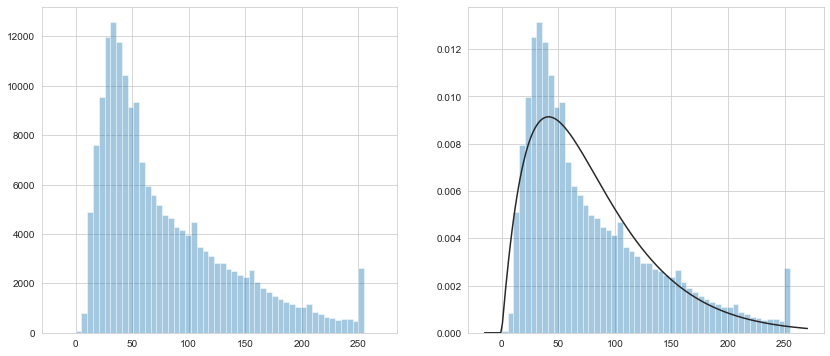

<Figure size 720x432 with 0 Axes>

In [30]:
plot_hist(images[0], 'beta');

# Провести обробку отриманих гістограм:
 - Провести апроксимацію гістограм з використанням імовірнісних розподілів:
     - Нормального (гаусового) розподілу
     - Розподілу Лапласа
     - Розподілу Стьюдента
     - Бета розподілу
 - Для кожної гістограми визначити найкращий тип апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення;
 - Побудувати розподіл отриманих апроксимацій за видом апроксимуючого розподілу;

In [31]:
def approx_array(img):
    img = img.reshape(-1)
    space = np.linspace(0,255,num=256)
    sse_min = 10**100
    res_distribution = None
    arr = []
    for i in range(256):
        arr.append(Counter(img)[i])
    
    for distribution in [norm, t, laplace, beta]:
        # fit dist to data
        params = distribution.fit(img)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        pdf = distribution.pdf(space, loc=loc, scale=scale, *arg)
            
        sse = np.sum(np.power(arr - pdf, 2.0))
            
        if sse <= sse_min:
            sse_min = sse
            res_distribution = distribution
    
    print(str(res_distribution).split('.')[3].split(' ')[0].split('_')[0])
    return res_distribution, sse_min, str(res_distribution).split('.')[3].split(' ')[0].split('_')[0]

In [32]:
def sample_stats(image):
    math_exp, variance, median, IQR_, kurtosis_, skew_ = count_statistics(image)
    print('=========== stats table ===========')
    print(tabulate([['math expectation', math_exp], 
                ['variance', variance], 
                ['median', median],
                ['IQR', IQR_],
                ['kurtosis', kurtosis_], 
                ['skew', skew_]]))
    
    distribution, sse, distribution_label = approx_array(image)
    print('=========== distribution approximation =========')
    print('distribution : ', distribution_label)
    print('squared error : ', sse)
    
    print('=========== Plotting graph =========')
    plot_hist(image, distribution_label)

161
=========== stats table ===========
----------------  -----------
math expectation   159.201
variance          5350.92
median             165
IQR                120
kurtosis            -0.88141
skew                -0.401269
----------------  -----------
beta
=========== distribution approximation =========
distribution :  beta
squared error :  266408259.40528667
=========== Plotting graph =========


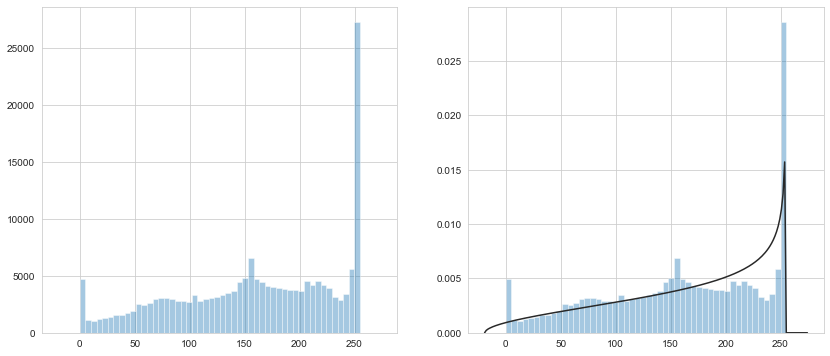

<Figure size 720x432 with 0 Axes>

************************************************************************************************************
202
=========== stats table ===========
----------------  -----------
math expectation   127.927
variance          6304.82
median             124
IQR                140
kurtosis            -1.25984
skew                 0.134105
----------------  -----------
beta
=========== distribution approximation =========
distribution :  beta
squared error :  174401535.1952047
=========== Plotting graph =========


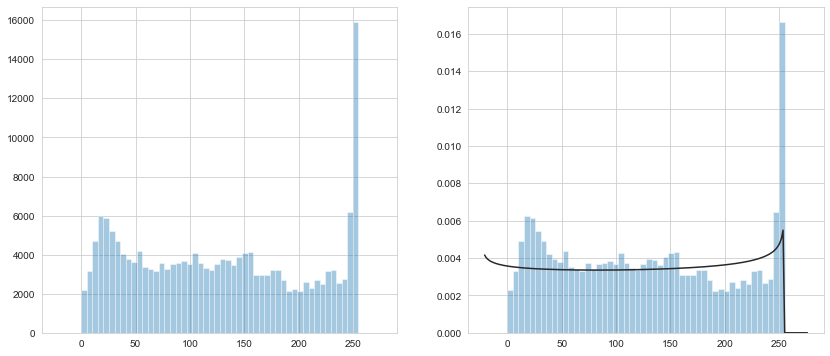

<Figure size 720x432 with 0 Axes>

************************************************************************************************************
136
=========== stats table ===========
----------------  ----------
math expectation    54.495
variance          2975.23
median              39
IQR                 62
kurtosis             1.88174
skew                 1.48587
----------------  ----------
beta
=========== distribution approximation =========
distribution :  beta
squared error :  302752580.19323677
=========== Plotting graph =========


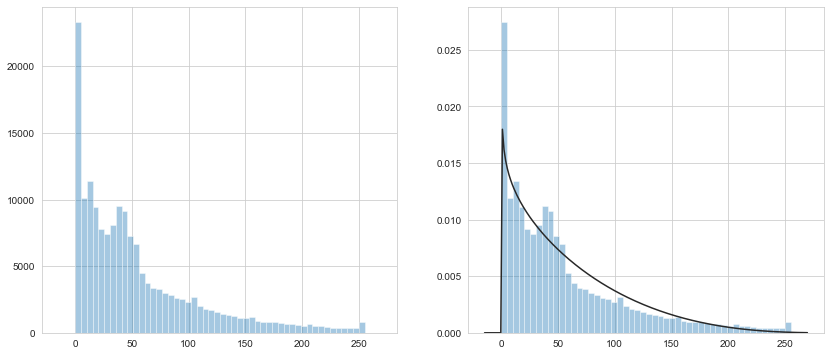

<Figure size 720x432 with 0 Axes>

************************************************************************************************************


In [33]:
n_samples = 3
for image_idx in np.random.choice(250, n_samples):
    print(image_idx)
    sample_stats(images[image_idx])
    print('******************************************************'*2)

# Побудувати багатовимірні гаусові моделі
Сформувати вектори параметрів розподілу значень яскравості пікселів тестових зображень:
 - Математичне очікування
 - Математичне очікування та дисперсія
 - Математичне очікування, дисперсія та коефіцієнт асиметрії
 - Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу

In [34]:
def group_statistics(data):
    math_exp_arr = []
    var_arr = []
    skew_arr = []
    kurt_arr = []
    for image in data:
        image_stats = count_statistics(image)
        math_exp_arr.append(image_stats[0])
        var_arr.append(image_stats[1])
        skew_arr.append(image_stats[4])
        kurt_arr.append(image_stats[5])
    return math_exp_arr, var_arr, skew_arr, kurt_arr

In [35]:
math_exp, var, skew, kurt = group_statistics(images)

Визначити параметри багатовимірних гаусових моделей для кожної групи векторів, відобразити їх графічно та у вигляді таблиць.

mean_vec:  107.41545217506075
cov_matrix: 
 1673.5359456864308


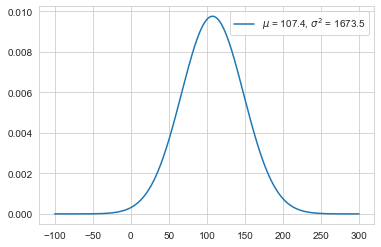

In [36]:
# 1. Math exp 
sample = math_exp
mean_vec_1 = np.mean(sample)
cov_matrix_1 = np.cov(sample)
print('mean_vec: ', mean_vec_1)
print('cov_matrix: \n', cov_matrix_1) 

x = np.linspace(start = -100, stop = 300, num = 2000)
y = norm(mean_vec_1, np.sqrt(cov_matrix_1)).pdf(x)
plt.plot(x, y, label = '$\mu$ = {}, $\sigma^2$ = {}'.format(np.round(mean_vec_1, 1), np.round(cov_matrix_1, 1)))
plt.legend();

mean_vec:  107.41545217506075 4243.408919072519
cov_matrix: 
 [[   1673.53594569   13880.98473311]
 [  13880.98473311 4366445.12780987]]


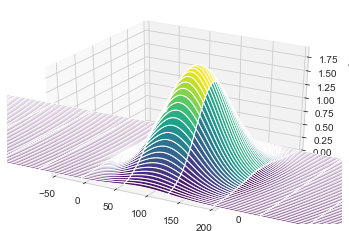

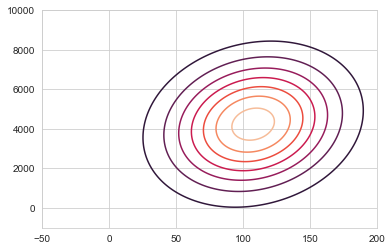

In [37]:
# 2. Math exp, Variance
sample = np.vstack((math_exp, var))
mean_vec_2 = np.mean(sample, axis=1)
cov_matrix_2 = np.cov(sample)
print('mean_vec: ', *mean_vec_2)
print('cov_matrix: \n', cov_matrix_2) 


x, y = np.mgrid[-500:3000, -1000:10000]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y
z = multivariate_normal(mean_vec_2, cov_matrix_2).pdf(position)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(-50, 200)
ax.set_ylim(-1000, 10000)
ax.plot_surface(x, y, z, cmap='viridis')
plt.show()

plt.xlim(-50, 200)
plt.ylim(-1000, 10000)
plt.contour(x, y, z)
plt.show()

In [38]:
# 3. Math exp, Variance, Skew
sample = np.vstack((math_exp, var, skew))
mean_vec_3 = np.mean(sample, axis=1)
cov_matrix_3 = np.cov(sample)
print('mean_vec: ', *mean_vec_3)
print('cov_matrix: \n', cov_matrix_3) 

mean_vec:  107.41545217506075 4243.408919072519 0.4199595228895673
cov_matrix: 
 [[   1673.53594569   13880.98473311     -29.28626586]
 [  13880.98473311 4366445.12780987   -3078.0709774 ]
 [    -29.28626586   -3078.0709774        9.5595654 ]]


In [39]:
# 4. Math exp, Variance, Skew, Kurtosis
sample = np.vstack((math_exp, var, skew, kurt))
mean_vec_4 = np.mean(sample, axis=1)
cov_matrix_4 = np.cov(sample)
print('mean_vec: ', *mean_vec_4)
print('cov_matrix: \n', cov_matrix_4)               

mean_vec:  107.41545217506075 4243.408919072519 0.4199595228895673 0.27798516994334505
cov_matrix: 
 [[   1673.53594569   13880.98473311     -29.28626586     -38.8191856 ]
 [  13880.98473311 4366445.12780987   -3078.0709774      -91.67834187]
 [    -29.28626586   -3078.0709774        9.5595654        0.94267026]
 [    -38.8191856      -91.67834187       0.94267026       1.14124183]]
